# **TP 3: OOD**

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import resnet18
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## **Training ResNet model**

This part of the code has been run on google colab notebook to get a GPU access. Rest of the notebook was run on my personnal computer with the weights I downloaded from google colab. 
I did put the code that was run on colab here for coherence purpose. The learning curves are available in the report that sums up all deliverables. 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Loading data : 

In [10]:
num_epochs = 100
batch_size = 128
num_classes = 100


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

We will train the model on 100 epochs, using the Adam optimizer. 

A desceasing learning rate is added through an scheduler. 

In [ ]:

model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean().item()


train_losses = []
train_accuracies = []
test_accuracies = []

# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    scheduler.step()

    #Evaluation
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_acc += accuracy(outputs, labels)

    test_acc /= len(test_loader)
    test_accuracies.append(test_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Train Acc: {epoch_acc:.4f} | "
        f"Test Acc: {test_acc:.4f}"
    )

save_path = os.path.join(os.getcwd(), "resnet18_cifar100.pth")
to_save = {
    'state_dict': model.state_dict(),
    'arch': 'resnet18',
    'num_classes': 100,
}

torch.save(to_save, save_path)


Let's visualise the learning curves : 

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()

print(f"Final Test Accuracy: {test_accuracies[-1] * 100:.2f}%")


In [ ]:
# Loading the model traned on colab

checkpoint = torch.load('/home/perann/Bureau/MVA/Theoretical deep learning/resnet18_cifar100.pth', map_location='cpu')
state_dict = checkpoint['state_dict']

model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(state_dict)

/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

## **Evaluation OOD Metrics**

In [14]:
from pytorch_ood.utils import OODMetrics
from torch.utils.data import DataLoader

Loading OOD dataset, CIFAR-10 for near OOD and SVHN for Far-OOD :

In [15]:
id_loader = test_loader 

transform_ood = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

ood_datasets = {
    "CIFAR10": torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform_ood, download=True),
    "SVHN": torchvision.datasets.SVHN(root="./data", split="test", transform=transform_ood, download=True),
}

ood_loaders = {name: DataLoader(ds, batch_size=128, shuffle=False) for name, ds in ood_datasets.items()}

We will compute the following OOD metrics : 

$MSP(x) = max(p(y = k | x))$ with $p(y|x) = softmax(f(x))$

$MLS(x) = max(z_{k})$ with $z = f(x)$, the logits

$E_{T}(x) = -T log(\Sigma_{k =1}^{K}e^{z_{k}/T})$

$M_{c} = (f(x)-\mu_{c})^{T}\Sigma^{-1}(f(x) - \mu_{c})$ with $\mu_{c}$ being mean feature for class $c$ and  $\Sigma$ a shared cov matrix.

$ViM(x)=E(x)−D_{⊥}​(x)$ with $D_{⊥}$ being 


To compute the Mahalanobis and the ViM metric, we need to get access to the mean feature per class, the $\Sigma$ cov matrix and the null space basis. We will compute those in the following cell using a forward hook :

In [19]:
features_dict = {}

def hook_fn(module, input, output):
    features_dict['feat'] = output.flatten(1) 

hook = model.avgpool.register_forward_hook(hook_fn)

feature_list = [[] for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)  
        feats = features_dict['feat']
        for c in range(num_classes):
            mask = (labels == c)
            if mask.sum() > 0:
                feature_list[c].append(feats[mask])

class_means = []
for feats in feature_list:
    feats_cat = torch.cat(feats, dim=0)
    class_means.append(feats_cat.mean(dim=0))
class_means = torch.stack(class_means)

all_feats = torch.cat([torch.cat(f, dim=0) for f in feature_list], dim=0)
cov = torch.from_numpy(np.cov(all_feats.cpu().numpy(), rowvar=False)).float()
precision = torch.linalg.inv(cov).to(device)


eigvals, eigvecs = torch.linalg.eigh(cov)
k = 50  
nullspace_basis = eigvecs[:, :k].to(device)

  0%|          | 0/391 [00:00<?, ?it/s]

100%|██████████| 391/391 [13:06:47<00:00, 120.74s/it]      


Computing OOD metrics

In [ ]:
def compute_scores(model, images):
    """ Helper function to compute OOD Metrics"""
    with torch.no_grad():
        logits = model(images)        

        softmax_probs = F.softmax(logits, dim=1)
        msp = torch.max(softmax_probs, dim=1).values

        max_logit = torch.max(logits, dim=1).values

        T = 1.0
        energy = -T * torch.logsumexp(logits / T, dim=1)

        features = features_dict['feat']

        mahalanobis_scores = []
        for feat in features:
            distances = [(feat - mu) @ precision @ (feat - mu).T for mu in class_means]
            mahalanobis_scores.append(-torch.min(torch.stack(distances))) 
        mahalanobis_scores = torch.stack(mahalanobis_scores)

        null_proj_norm = (features @ nullspace_basis).norm(dim=1)
        vim_scores =  max_logit - null_proj_norm

    return msp, max_logit, energy, mahalanobis_scores, vim_scores


In [21]:
from sklearn.metrics import roc_curve, auc

# Define which direction is higher for OOD detection
metric_directions = {
    'MSP': False,          # higher MSP = confident ID
    'MaxLogit': False,     # higher logit = confident ID
    'Energy': True,        # higher energy = more likely OOD
    'Mahalanobis': False,  # higher Mahalanobis = confident ID
    'ViM': False           # higher ViM = confident ID
}

metric_names = ["MSP", "MaxLogit", "Energy", "Mahalanobis", "ViM"]


all_scores_dict = {} 
id_scores_dict = {}  

for ood_name, ood_loader in ood_loaders.items():
    print(f"Evaluating OOD scores for: {ood_name}")

    all_scores = {k: [] for k in metric_names}
    all_labels = []

    # ID samples
    for images, labels in tqdm(id_loader, desc="ID"):
        images = images.to(device)
        msp, max_logit, energy, mahalanobis, vim = compute_scores(model, images)
        for k, v in zip(metric_names, [msp, max_logit, energy, mahalanobis, vim]):
            all_scores[k].append(v.cpu())
        all_labels.append(labels)

    # OOD samples
    for images, _ in tqdm(ood_loader, desc="OOD"):
        images = images.to(device)
        msp, max_logit, energy, mahalanobis, vim = compute_scores(model, images)
        for k, v in zip(metric_names, [msp, max_logit, energy, mahalanobis, vim]):
            all_scores[k].append(v.cpu())
        all_labels.append(torch.full((len(images),), -1, dtype=torch.long))

    for k in all_scores:
        all_scores[k] = torch.cat(all_scores[k]).numpy()
    all_labels = torch.cat(all_labels).numpy()

    all_scores_dict[ood_name] = all_scores
    if 'ID' not in id_scores_dict:
        # Store ID scores separately
        id_mask = all_labels != -1
        id_scores_dict['ID'] = {k: all_scores[k][id_mask] for k in metric_names}



Evaluating OOD scores for: CIFAR10


ID:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_78831/1673786259.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  distances = [(feat - mu) @ precision @ (feat - mu).T for mu in class_means]
OOD: 100%|██████████| 79/79 [03:00<00:00,  2.29s/it]



Evaluating OOD scores for: SVHN


OOD: 100%|██████████| 204/204 [07:38<00:00,  2.25s/it]


Plotting the ROC AUC Curves :

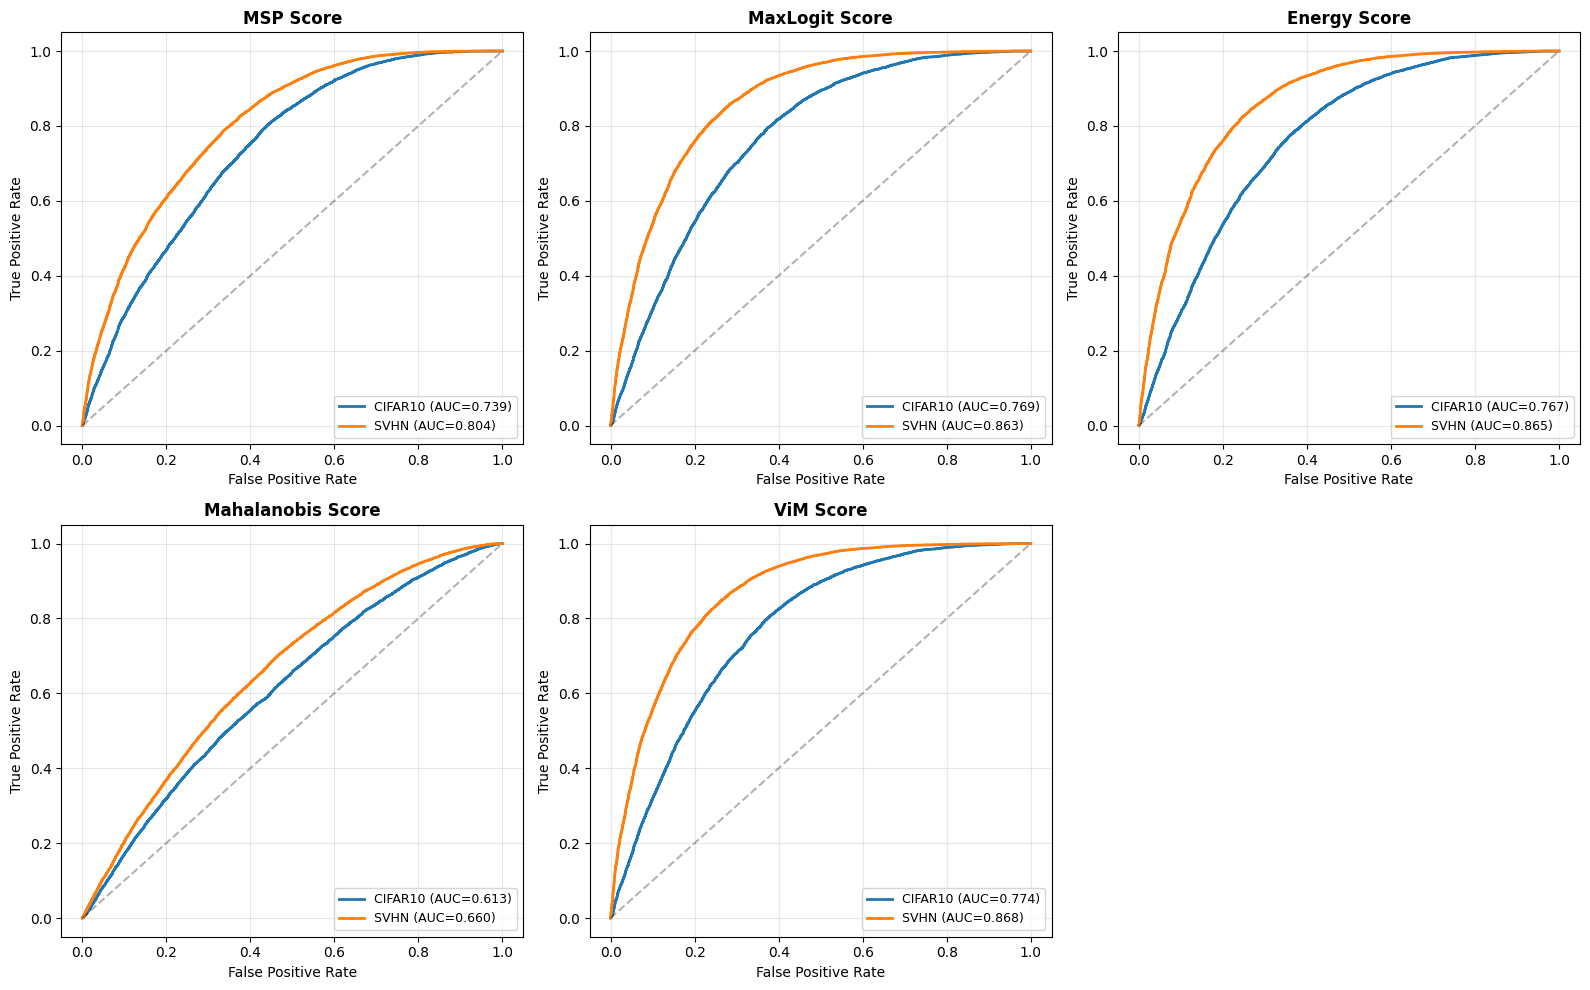

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, metric in enumerate(metric_names):
    
    ax = axes[idx]
    higher_is_ood = metric_directions[metric]

    for ood_idx, (ood_name, scores) in enumerate(all_scores_dict.items()):
        y_true = np.concatenate([
            np.zeros_like(id_scores_dict['ID'][metric]),
            np.ones(len(scores[metric]) - len(id_scores_dict['ID'][metric]))
        ])
        y_score = np.concatenate([
            id_scores_dict['ID'][metric],
            scores[metric][len(id_scores_dict['ID'][metric]):]
        ])
        y_score = y_score if higher_is_ood else -y_score

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=f'{ood_name} (AUC={roc_auc:.3f})', color=colors[ood_idx % len(colors)], linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)


axes[-1].axis('off')
plt.tight_layout()
plt.savefig('./ood_roc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

As expected, classification is better for images of the far OOD dataset (SVHN). 

The worst metric for separation here is the Mahalanobis score, but it stil performs above random classifier. The metric with the best ROC AUC Score is ViM, max logit and Ernergy score have slightly lower performances.

## **Neural Collapse**

NC 1 : As training progresses toward zero loss, the features of samples belonging to the same class collapse to their class mean.

In [31]:
class_means = class_means.to(device)
global_mean = class_means.mean(dim=0)

Sw = 0.0
for c in range(num_classes):
    feats_c = torch.cat(feature_list[c], dim=0).to(device)  # [Nc, D]
    mu_c = class_means[c]
    Sw += ((feats_c - mu_c) ** 2).sum() / feats_c.shape[0]

Sb = ((class_means - global_mean) ** 2).sum()

nc1 = (Sw / Sb).item()
print(f"NC1 (within,  between variance): {nc1:.6f}")


NC1 (within,  between variance): 1.031723


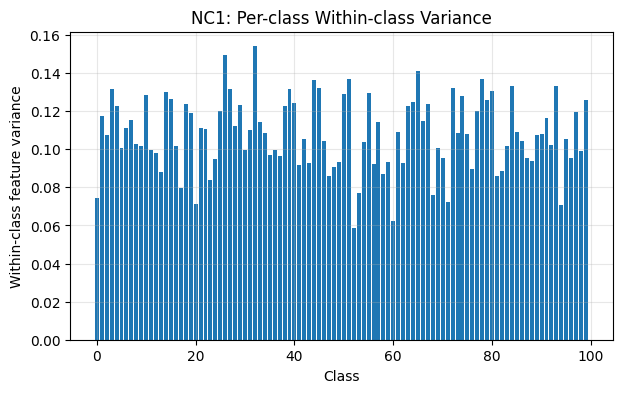

In [32]:
per_class_var = []

for c in range(num_classes):
    feats_c = torch.cat(feature_list[c], dim=0).to(device)
    mu_c = class_means[c]
    var_c = ((feats_c - mu_c) ** 2).mean().item()
    per_class_var.append(var_c)

plt.figure(figsize=(7,4))
plt.bar(range(num_classes), per_class_var)
plt.ylabel("Within-class feature variance")
plt.xlabel("Class")
plt.title("NC1: Per-class Within-class Variance")
plt.grid(alpha=0.3)
plt.show()

NC2 : The class means are arranged in a maximally symmetric configuration called a Simplex Equiangular Tight Frame (ETF).

In [37]:

M = class_means - global_mean
M_norm = M / M.norm(dim=1, keepdim=True)
cosine_matrix = M_norm @ M_norm.T

mask = ~torch.eye(num_classes, dtype=torch.bool, device=device)
off_diag_cos = cosine_matrix[mask]

nc2_mean = off_diag_cos.mean().item()
nc2_std = off_diag_cos.std().item()

print(f"NC2 mean off-diagonal cosine: {nc2_mean:.6f}")
print(f"NC2 std  off-diagonal cosine: {nc2_std:.6f}")

print(f"ETF target: {-1 / (num_classes - 1):.6f}")


NC2 mean off-diagonal cosine: -0.009734
NC2 std  off-diagonal cosine: 0.179840
ETF target: -0.010101


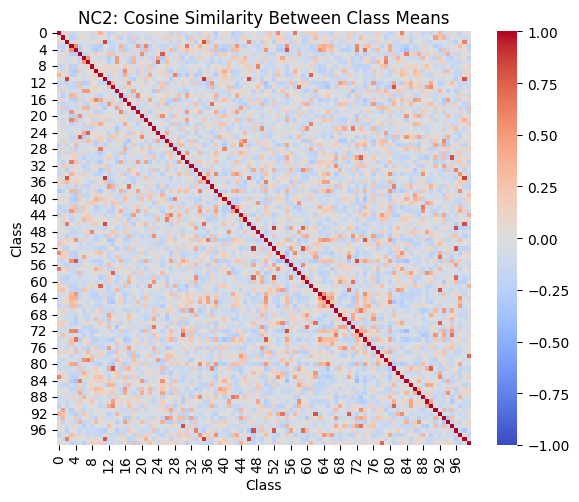

In [38]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cosine_matrix.detach().cpu(),
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True
)
plt.title("NC2: Cosine Similarity Between Class Means")
plt.xlabel("Class")
plt.ylabel("Class")
plt.tight_layout()
plt.show()


NC3 : At the terminal phase of training, the linear classifier weights align with the class means in feature space.

NC3 mean cosine(W, mu): 0.587903
NC3 std  cosine(W, mu): 0.035726


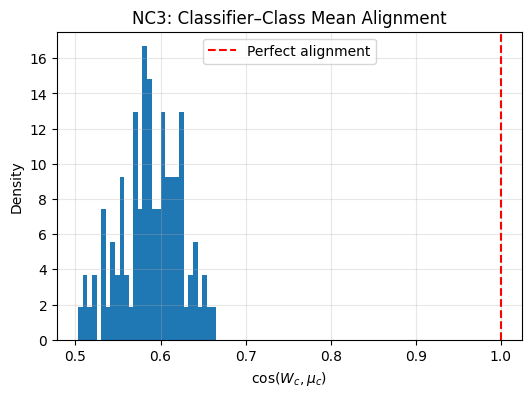

In [ ]:
# Classifier weights
W = model.fc.weight.data.to(device) 

# Normalize
W_norm = W / W.norm(dim=1, keepdim=True)
M_norm = class_means / class_means.norm(dim=1, keepdim=True)

# Cosine similarity per class
alignment = (W_norm * M_norm).sum(dim=1)

nc3_mean = alignment.mean().item()
nc3_std = alignment.std().item()

print(f"NC3 mean cosine(W, mu): {nc3_mean:.6f}")
print(f"NC3 std  cosine(W, mu): {nc3_std:.6f}")



plt.figure(figsize=(6, 4))
plt.hist(alignment.detach().cpu().numpy(), bins=30, density=True)
plt.axvline(1.0, color='r', linestyle='--', label='Perfect alignment')
plt.xlabel(r'$\cos(W_c, \mu_c)$')
plt.ylabel('Density')
plt.title('NC3: Classifier–Class Mean Alignment')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Here we see that NC3 is not fully reached, which is coherent as we are not in a specific over-parametrised case. 

NC4 : If the network has collapsed well, this nearest‑class‑mean rule will produce the same predicted labels as the full softmax classifier on training dat

NC4 margins: 100%|██████████| 391/391 [09:23<00:00,  1.44s/it]


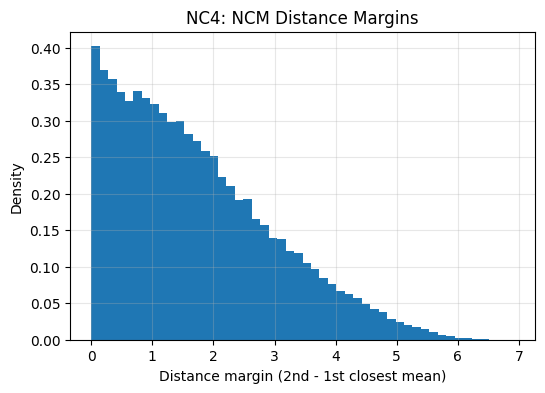

In [41]:
margins = []

with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="NC4 margins"):
        images = images.to(device)

        _ = model(images)
        feats = features_dict['feat']
        dists = torch.cdist(feats, class_means) 

        sorted_dists, _ = torch.sort(dists, dim=1)
        margin = sorted_dists[:, 1] - sorted_dists[:, 0]
        margins.append(margin.cpu())

margins = torch.cat(margins)

plt.figure(figsize=(6, 4))
plt.hist(margins.numpy(), bins=50, density=True)
plt.xlabel("Distance margin (2nd - 1st closest mean)")
plt.ylabel("Density")
plt.title("NC4: NCM Distance Margins")
plt.grid(alpha=0.3)
plt.show()


NC5

NC5: 100%|██████████| 391/391 [08:32<00:00,  1.31s/it]


NC5 logit–distance correlation: 0.164625


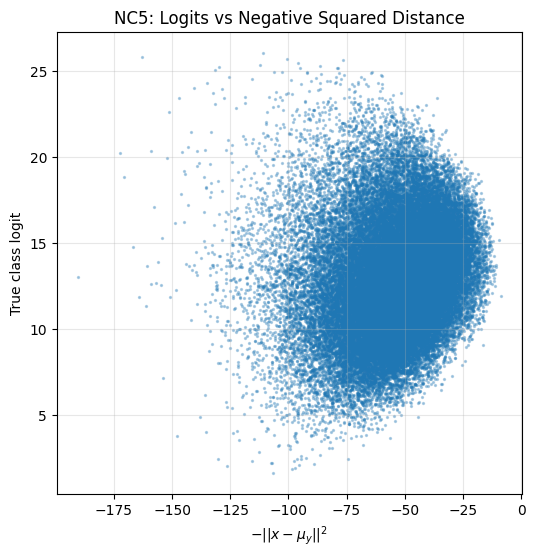

In [ ]:
all_logits = []
all_neg_sq_dists = []

with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="NC5"):
        images = images.to(device)
        
        labels = labels.to(device)

        logits = model(images)              
        feats = features_dict['feat']        

        dists_sq = torch.cdist(feats, class_means) ** 2  
        neg_dists_sq = -dists_sq

        true_logits = logits.gather(1, labels.unsqueeze(1)).squeeze(1)
        true_neg_dists = neg_dists_sq.gather(1, labels.unsqueeze(1)).squeeze(1)

        all_logits.append(true_logits.cpu())
        all_neg_sq_dists.append(true_neg_dists.cpu())

all_logits = torch.cat(all_logits).numpy()
all_neg_sq_dists = torch.cat(all_neg_sq_dists).numpy()

corr = np.corrcoef(all_logits, all_neg_sq_dists)[0, 1]
print(f"NC5 logit–distance correlation: {corr:.6f}")


plt.figure(figsize=(6, 6))
plt.scatter(
    all_neg_sq_dists,
    all_logits,
    s=2,
    alpha=0.3
)
plt.xlabel(r"$-||x - \mu_{y}||^2$")
plt.ylabel("True class logit")
plt.title("NC5: Logits vs Negative Squared Distance")
plt.grid(alpha=0.3)
plt.show()

## **NECO**

By assembling the previous NC, we can compute the NECO OOD metric.

class_means: torch.Size([100, 512])
features D: 512
nullspace_basis: torch.Size([512, 412])


NECO Scoring: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


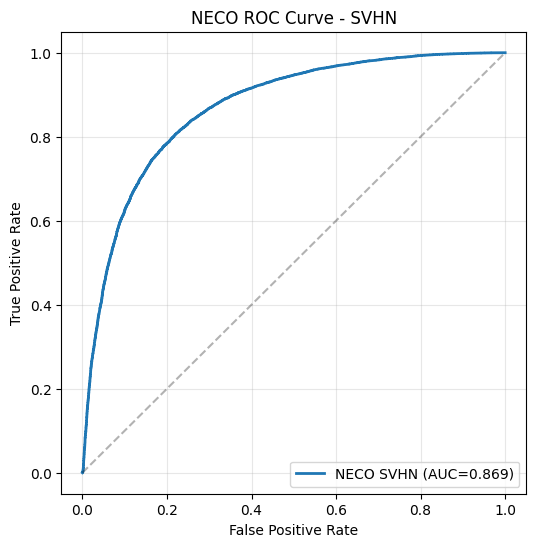

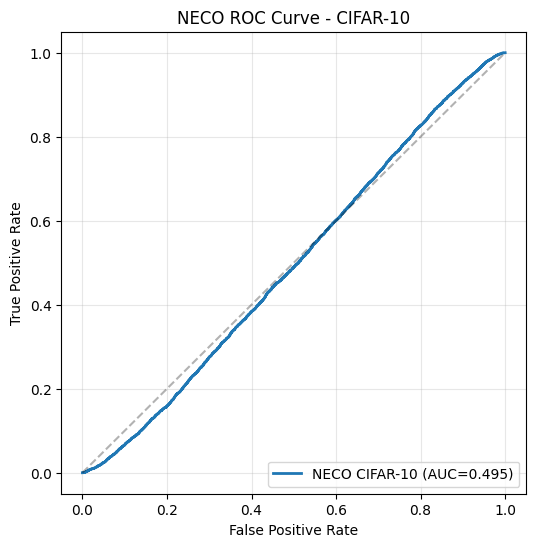

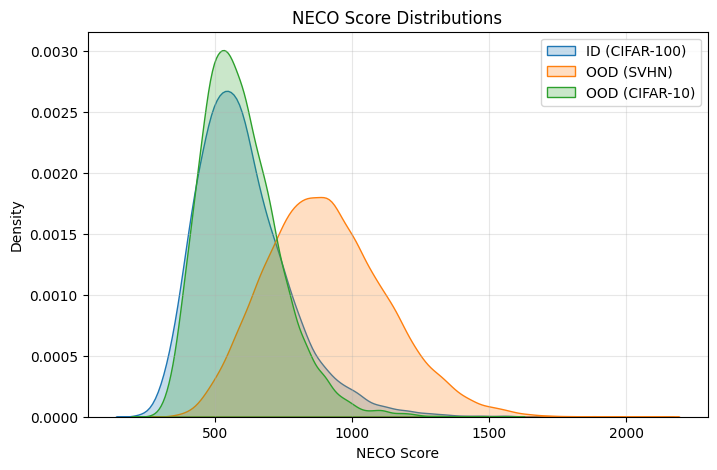

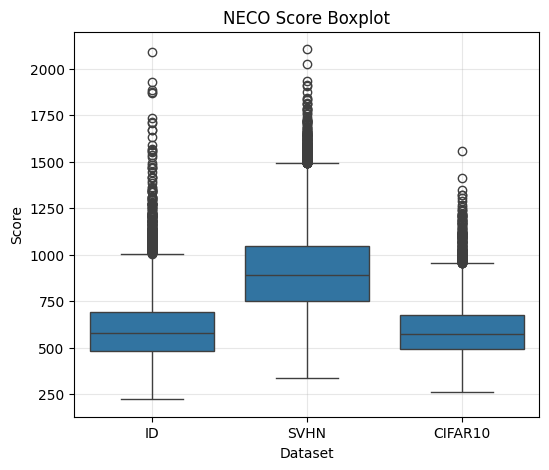

NECO ID mean: 604.5758666992188
NECO SVHN mean: 907.4556884765625
NECO CIFAR-10 mean: 593.8378295898438


In [ ]:
class_means = torch.stack([torch.cat(f, dim=0).mean(0) for f in feature_list]).to(device)

all_feats = torch.cat([torch.cat(f, dim=0) for f in feature_list], dim=0).to(device)
cov = torch.from_numpy(np.cov(all_feats.cpu().numpy(), rowvar=False)).float().to(device)
precision = torch.linalg.inv(cov)

U, S, Vh = torch.linalg.svd(class_means - class_means.mean(0))
nullspace_basis = Vh.T[:, num_classes:]  



def neco_score(features, class_means, precision, nullspace_basis, lambda_=1.0):
    """Neco score function"""
    maha_dists = []
    for c in range(class_means.shape[0]):
        delta = features - class_means[c]
        maha = torch.sum((delta @ precision) * delta, dim=1)
        maha_dists.append(maha.unsqueeze(1))

    min_maha = torch.cat(maha_dists, dim=1).min(dim=1).values

    null_proj = features @ nullspace_basis
    null_energy = (null_proj ** 2).sum(dim=1)

    return min_maha + lambda_ * null_energy

def compute_neco_scores(model, data_loader):
    """ helper function to compute the Neco score"""
    model.eval()
    scores_list = []
    with torch.no_grad():
        for images, _ in tqdm(data_loader, desc="NECO Scoring"):
            images = images.to(device)
            _ = model(images)
            feats = features_dict['feat']  # [B, D]
            scores = neco_score(feats, class_means, precision, nullspace_basis)
            scores_list.append(scores.cpu())
    return torch.cat(scores_list)

neco_id = compute_neco_scores(model, id_loader)
neco_svhn = compute_neco_scores(model, ood_loaders['SVHN'])
neco_c10  = compute_neco_scores(model, ood_loaders['CIFAR10'])


def plot_neco_roc(neco_id, neco_ood, ood_name):
    y_true = np.concatenate([np.zeros_like(neco_id), np.ones_like(neco_ood)])
    y_scores = np.concatenate([neco_id, neco_ood])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, linewidth=2, label=f'NECO {ood_name} (AUC={roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--', alpha=0.3)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"NECO ROC Curve - {ood_name}")
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
    return roc_auc

auc_svhn = plot_neco_roc(neco_id.numpy(), neco_svhn.numpy(), "SVHN")
auc_c10  = plot_neco_roc(neco_id.numpy(), neco_c10.numpy(), "CIFAR-10")

plt.figure(figsize=(8,5))
sns.kdeplot(neco_id.numpy(), label="ID (CIFAR-100)", fill=True)
sns.kdeplot(neco_svhn.numpy(), label="OOD (SVHN)", fill=True)
sns.kdeplot(neco_c10.numpy(), label="OOD (CIFAR-10)", fill=True)
plt.xlabel("NECO Score")
plt.ylabel("Density")
plt.title("NECO Score Distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


df = pd.DataFrame({
    "Score": np.concatenate([neco_id, neco_svhn, neco_c10]),
    "Dataset": ["ID"]*len(neco_id) + ["SVHN"]*len(neco_svhn) + ["CIFAR10"]*len(neco_c10)
})
plt.figure(figsize=(6,5))
sns.boxplot(x="Dataset", y="Score", data=df)
plt.title("NECO Score Boxplot")
plt.grid(alpha=0.3)
plt.show()

print("NECO ID mean:", neco_id.mean().item())
print("NECO SVHN mean:", neco_svhn.mean().item())
print("NECO CIFAR-10 mean:", neco_c10.mean().item())


NECO performs really well on far OOD, but poorly on near OOD (slighlty less than a random classifier). Probably because neural collapse is not fully reached.